In [3]:
import pandas as pd
from PIL import Image
import os
import clip
import torch

/home/ho2298/anaconda3/envs/openaiclip/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

## Creating Imagenet DF 

In [48]:
def make_adverserial_inference_df(inference_path, fgsm = False):
    '''
    Create dataframe for our inference files
    inference_path: path to our inference folder 
    
    retunrs df with image pointing to image filename and caption to the correct label 
    '''
    #file_path_names = [f for f in os.listdir(inference_path) if os.path.isfile(f)]
    file_path_names = os.listdir(inference_path)
    d = {} 
    files = []
    labels = []
    captions = []
    for file_path in file_path_names:
        full_path = os.path.join(os.getcwd(), inference_path, file_path)
        if fgsm:
            name = os.path.splitext(file_path)[0] # remove .JPEG from the end 
            name = ' '.join(name.split('_'))  # "01669191_box_turtle"  to "box turtle"
            label = name
            name = "This is a photo of a " + name  # "box turtle" to "This is box turtle"
        else:
            name = os.path.splitext(file_path)[0] # remove .JPEG from the end 
            name = ' '.join(name.split('_')[1:])  # "01669191_box_turtle"  to "box turtle"
            label = name
            name = "This is a photo of a " + name  # "box turtle" to "This is box turtle"
        captions.append(name)
        labels.append(label)
        files.append(full_path)
    d['image'] = files
    d['caption'] = captions 
    d['label'] = labels
    df = pd.DataFrame(data=d)
    
    return df 

In [49]:
og_df = make_adverserial_inference_df("data/originalImagenet")

In [18]:
og_df.iloc[0]

image      /home/ho2298/practdl/AdversarialCLIPRobustness...
caption                 This is a photo of a cassette player
label                                        cassette player
Name: 0, dtype: object

In [47]:
#!python -m pip install -U matplotlib

## Test adding Gaussian Noise to Imagenet image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


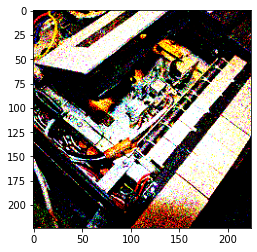

In [50]:
import matplotlib.pyplot as plt
from torchvision import transforms
image = Image.open(og_df.iloc[0]['image']).convert('RGB')
preprocess_inf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

In [36]:
image.shape

torch.Size([3, 224, 224])

In [37]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [45]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
preprocess.transforms.append(AddGaussianNoise(0, 0.5))
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fc13e2f5550>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    AddGaussianNoise(mean=0, std=0.5)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


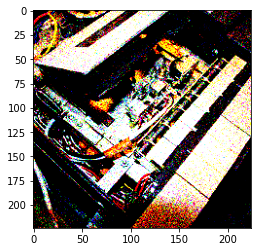

In [46]:

image = Image.open(og_df.iloc[0]['image']).convert('RGB')
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0).float())

## Finetuning CLIP model 
### Example finetune reference here: https://github.com/openai/CLIP/issues/83

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader

class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt):

        self.image_path = list_image_path
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.
        
    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):

        image = Image.open(self.image_path[idx]).convert('RGB')
        image = preprocess(image)
        #image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        title = self.title[idx]
        return image,title

In [67]:
#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [68]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

In [76]:
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim 

def write_logs(file_name, message):
    f = open(file_name, "a")
    f.write(message + '\n')
    f.close()
    
def train(df, lr=5e-5, noise=None, epochs=10, batch_size=64):
    device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
    model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
    if noise is not None:
        preprocess.transforms.append(AddGaussianNoise(0, noise))
    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()
    #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
    optimizer = optim.Adam(model.parameters(), lr ,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) 
    
    list_image_path = df['image'].values
    list_txt = df['caption'].values
    dataset = image_title_dataset(list_image_path,list_txt)
    train_dataloader = DataLoader(dataset,batch_size = batch_size) #Define your own dataloader
    best_loss = float("inf")
    log_file_name = f"Gaussian_{noise}_train_logs"
    for epoch in tqdm(range(epochs), total=epochs):
        loss_meter = AvgMeter()
        for batch in train_dataloader:
            optimizer.zero_grad()
            images, texts = batch 
            images = images.to(device)
            texts = texts.to(device)
            logits_per_image, logits_per_text = model(images, texts)
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            total_loss.backward()
            count = images.size(0)
            loss_meter.update(total_loss.item(), count)
            
            if device == "cpu":
                optimizer.step()
            else: 
                convert_models_to_fp32(model)
                optimizer.step()
                clip.model.convert_weights(model)
            
        if loss_meter.avg < best_loss:
            best_loss= loss_meter.avg
            torch.save(model.state_dict(), f"model_checkpoints/Gaussian_{noise}_{epoch}_best.pt")
            print("Saved Best Model!")
            
        write_logs(log_file_name, f"{epoch}, {loss_meter.avg:.5f}, {best_loss:.5f}")             
        print(f"Epoch: {epoch + 1}, train_loss: {loss_meter.avg:.5f}, best_loss: {best_loss:.5f}")

In [ ]:
og_df = make_adverserial_inference_df("data/originalImagenet")
noise_list = [0.4, 0.6, 0.8, 1]
for g_noise in noise_list:
    print(f"Training with Gaussian Noise {g_noise}")
    train(og_df, noise=g_noise )

Training with Gaussian Noise 0.4


 10%|██████████████▍                                                                                                                                 | 1/10 [00:20<03:07, 20.84s/it]

Saved Best Model!
Epoch: 1, train_loss: 1.51014, best_loss: 1.51014


 20%|████████████████████████████▊                                                                                                                   | 2/10 [00:39<02:37, 19.74s/it]

Saved Best Model!
Epoch: 2, train_loss: 0.45350, best_loss: 0.45350


 30%|███████████████████████████████████████████▏                                                                                                    | 3/10 [00:58<02:15, 19.38s/it]

Saved Best Model!
Epoch: 3, train_loss: 0.15422, best_loss: 0.15422


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 4/10 [01:17<01:55, 19.24s/it]

Saved Best Model!
Epoch: 4, train_loss: 0.15220, best_loss: 0.15220


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 5/10 [01:36<01:34, 18.89s/it]

Epoch: 5, train_loss: 0.16591, best_loss: 0.15220


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6/10 [01:54<01:14, 18.65s/it]

Epoch: 6, train_loss: 0.32058, best_loss: 0.15220


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7/10 [02:12<00:55, 18.49s/it]

Epoch: 7, train_loss: 0.34482, best_loss: 0.15220


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8/10 [02:30<00:36, 18.39s/it]

Epoch: 8, train_loss: 0.31675, best_loss: 0.15220


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9/10 [02:48<00:18, 18.33s/it]

Epoch: 9, train_loss: 0.33530, best_loss: 0.15220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:06<00:00, 18.69s/it]

Epoch: 10, train_loss: 0.39875, best_loss: 0.15220
Training with Gaussian Noise 0.6



 10%|██████████████▍                                                                                                                                 | 1/10 [00:19<02:51, 19.09s/it]

Saved Best Model!
Epoch: 1, train_loss: 1.57783, best_loss: 1.57783


 20%|████████████████████████████▊                                                                                                                   | 2/10 [00:38<02:32, 19.07s/it]

Saved Best Model!
Epoch: 2, train_loss: 0.49872, best_loss: 0.49872


 30%|███████████████████████████████████████████▏                                                                                                    | 3/10 [00:57<02:13, 19.05s/it]

Saved Best Model!
Epoch: 3, train_loss: 0.19072, best_loss: 0.19072


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 4/10 [01:16<01:54, 19.06s/it]

Saved Best Model!
Epoch: 4, train_loss: 0.10908, best_loss: 0.10908


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 5/10 [01:34<01:33, 18.79s/it]

Epoch: 5, train_loss: 0.12235, best_loss: 0.10908


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6/10 [01:52<01:14, 18.62s/it]

Epoch: 6, train_loss: 0.27520, best_loss: 0.10908


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7/10 [02:10<00:55, 18.45s/it]

Epoch: 7, train_loss: 0.39120, best_loss: 0.10908


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8/10 [02:29<00:36, 18.41s/it]

Epoch: 8, train_loss: 0.44289, best_loss: 0.10908


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9/10 [02:47<00:18, 18.32s/it]

Epoch: 9, train_loss: 0.36760, best_loss: 0.10908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:05<00:00, 18.56s/it]

Epoch: 10, train_loss: 0.30537, best_loss: 0.10908
Training with Gaussian Noise 0.8



 10%|██████████████▍                                                                                                                                 | 1/10 [00:19<02:52, 19.13s/it]

Saved Best Model!
Epoch: 1, train_loss: 1.46297, best_loss: 1.46297


 20%|████████████████████████████▊                                                                                                                   | 2/10 [00:38<02:32, 19.12s/it]

Saved Best Model!
Epoch: 2, train_loss: 0.55198, best_loss: 0.55198


 30%|███████████████████████████████████████████▏                                                                                                    | 3/10 [00:57<02:13, 19.10s/it]

Saved Best Model!
Epoch: 3, train_loss: 0.24626, best_loss: 0.24626


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 4/10 [01:16<01:55, 19.18s/it]

Saved Best Model!
Epoch: 4, train_loss: 0.13433, best_loss: 0.13433


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 5/10 [01:34<01:34, 18.88s/it]

Epoch: 5, train_loss: 0.14130, best_loss: 0.13433


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6/10 [01:53<01:14, 18.66s/it]

Epoch: 6, train_loss: 0.19637, best_loss: 0.13433


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7/10 [02:11<00:55, 18.47s/it]

Epoch: 7, train_loss: 0.28546, best_loss: 0.13433


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8/10 [02:29<00:36, 18.34s/it]

Epoch: 8, train_loss: 0.40816, best_loss: 0.13433


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9/10 [02:47<00:18, 18.28s/it]

Epoch: 9, train_loss: 0.52460, best_loss: 0.13433


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:05<00:00, 18.56s/it]

Epoch: 10, train_loss: 0.30458, best_loss: 0.13433
Training with Gaussian Noise 1



 10%|██████████████▍                                                                                                                                 | 1/10 [00:19<02:51, 19.05s/it]

Saved Best Model!
Epoch: 1, train_loss: 1.74730, best_loss: 1.74730


 20%|████████████████████████████▊                                                                                                                   | 2/10 [00:38<02:32, 19.01s/it]

Saved Best Model!
Epoch: 2, train_loss: 0.59567, best_loss: 0.59567


 30%|███████████████████████████████████████████▏                                                                                                    | 3/10 [00:57<02:13, 19.08s/it]

Saved Best Model!
Epoch: 3, train_loss: 0.18514, best_loss: 0.18514


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 4/10 [01:16<01:54, 19.09s/it]

Saved Best Model!
Epoch: 4, train_loss: 0.10040, best_loss: 0.10040


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 5/10 [01:34<01:33, 18.75s/it]

Epoch: 5, train_loss: 0.11939, best_loss: 0.10040


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6/10 [01:52<01:14, 18.56s/it]

Epoch: 6, train_loss: 0.26182, best_loss: 0.10040
